# Lab 5 - Evaluation and Multi-Layer Perceptron

### Eric Smith and Jake Carlson

## Introduction
In this lab, we will develop a multi-layer perceptron to perform classification on the CIFAR-10 data set. Similar to Lab 3, we will subset the data set to images of trucks and automobiles. The original data set has 60,000 images. 50,000 of these are training images and 10,000 are test images. The images are 32x32 pixels and contain objects from 10 classes. The classes are listed below.
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

This data set was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton for their paper <i>Learning Multiple Layers of Features from Tiny Images</i>. In this study, the authors use several filters to train their model to learn interesting regularities in the set of images, rather than focus on correlations between nearby pixels [1].

For this lab, we will use the images of automobile, trucks, and birds. The trucks, in this case, are semi-trucks. We have been guaranteed by the people who generated the data set that these three classes are mutually exclusive. The automobile class will have images of sedans and SUVs. The truck class will have big trucks only. Neither class has images of pickup trucks. Furthermore, the birds image set has close ups of serveral species of bird.

## Business Understanding

### Motivations
The law treats cars and trucks differently on the road. Trucks often have to stop at weigh stations so their contents can be verified. It would be useful to have a tool that can distinguish between cars and trucks. Once a truck has been identified, a record of the truck and its location can be made so that Customs or local authorities can make sure the truck is checked at the next weigh station.

The classification system developed could be deployed in conjunction with CCTV cameras on the highway. This would give authorities real time metrics on how many trucks are passing through an area. If a truck passes by two cameras, our model could incorporate the location of each camera and the time between sightings. This would reduce the necessity of having police officers on the road to monitor the speed of semi-trucks.

If a truck is identified as speeding, a police officer could be dispatched to monitor the vehicle. Using a distributed network of cameras on the highway would mean officers could spend more time patrolling residential and commerical areas. The average annual income for a Texas state trooper is \$60,612 [2]. Positioning a trooper on the highway costs roughly \$31 an hour. Meanwhile, the cost of running a CCTV camera 24/7 is approximately 54 cents per month [3].

If a trooper is positioned on the highway, people alter their behaviors because they recognize that they are being monitored. If a criminal organization is transporting illicit substances, they can have a lead car drive ahead of the transport truck so officers can be located before the truck passes through an area. However, people often don't recognize when they are being monitored by CCTV camera.

Finally, we are using the images of birds in our modeling to help account for any errors in the snapshots captured by CCTVs. If a bird were to fly infront of the camera, it could easily be interpreted as a truck by a model that wasn't trained to account for this error. Although it is not our main objective, doing this will help us lower our model's false positive rate.

### Objectives
Our main objective is to accurately pick out a semi-truck from a sea of automobiles and birds. A state trooper can accurately distinguish between a semi-truck, automobile, and (hopefully) bird 100% of the time. But troopers rotate in and out of an area, leaving gaps in the amount of time a road is being monitored. Take the following simplified case: one trooper is assigned to watch a highway for one business day where they start at 8am, end at 5pm, and take an hour for lunch. A second trooper rotates in to monitor the highway starting at 6pm and ending at 3am. The percentage of time the road is covered is given by
<br><br>
$$t_{officer} = \frac{24 - ((6-5) + 1 + (6-3))}{24}\times100 = 79.2\%$$


<br><br>
So 79% is our threshold to beat. In order for our algorithm to be useful to authorities, it must minimize the number of trucks that slip through undetected. We will do this by measuring the performance of our model with Recall Macro such that
<br><br>

$$Recall_{macro} = \frac{ TP_{1} + ... + TP_{k}}{TP_{1} + ... + TP_{k} + FN_{1} + ... + FN_{k}}$$
<br>
With recall macro, we are weighting all classes equally, regardless of class distribution. This is because we want to minimize the number of trucks that are classified as birds or cars.

Therefore, our objective is to minimize the number of false negatives produced and reach 79% recall to be a viable replacement for police officers.

## Data Preparation

### Data Cleaning
We will start by loading the images and subsetting to 1000 images. We will use a ratio of cars to trucks that most closely matches real-world dirving conditions. A project at The George Washington University [2] puts the percentage of highway vehicles that are trucks anywhere between 5% and 25% depeding on the stretch of road. We will use 25% because it balances the classes as much as possible while still conforming to a real-world estimate of the ratio between trucks and cars. We will then clean the data by extracting features using Daisy. Daisy was shown to be the most useful at finding similar images in Lab 3. Then we will reduce the dimensionality of the Daisy bag of features using PCA. We will select the features that explain the most variance in our data set.

In [69]:
import numpy as np
import pandas as pd

df_labels = pd.read_csv('../Lab3/data/labels.csv')
df_labels = df_labels[ df_labels.label.isin(['automobile', 'truck', 'bird']) ]
df_labels = pd.concat([df_labels[df_labels.label == "truck"].sample(n=200),
                      df_labels[df_labels.label == "automobile"].sample(n=700),
                      df_labels[df_labels.label == "bird"].sample(n=100)])

df_labels.head()

id  label
44588  44589  truck
22333  22334  truck
18800  18801  truck
4340    4341  truck
4970    4971  truck

In [70]:
from PIL import Image

# reads a png and returns a list of all pixel values in order r, g, b
def get_img_as_rgb_row(image_path):
    img = Image.open(image_path)
    if len(img.split()) == 4:
        # remove alpha if present
        r, g, b, a = img.split()
        img = Image.merge("RGB", (r, g, b))
    r, g, b = img.split()
    r = list(r.getdata())
    g = list(g.getdata())
    b = list(b.getdata())
    # convert to gray scale
    img_list = [(r[i] * 0.2989 + g[i] * 0.5870 + b[i] * 0.1140) for i in range(len(r))]
    return img_list

# generate column names
cols = ['label']
for i in range(1024):
    cols.append("{}".format(i))

# create df and extract color values for all car and truck images
df = pd.DataFrame(columns=cols, index=range(len(df_labels.id.tolist())))
data_dir = "../Lab3/data/cifar-10/"
idx = 0
for r in df_labels.iterrows():
    entry = [r[1].label]
    entry.extend(get_img_as_rgb_row("{}{}.png".format(data_dir, r[1].id)))
    df.loc[idx] = entry
    idx += 1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 1025 entries, label to 1023
dtypes: object(1025)
memory usage: 7.8+ MB


In [71]:
df.head()

label        0        1        2        3        4        5        6  \
0  truck  254.974  254.974  254.974  254.974   253.85   253.85   253.85   
1  truck  115.929   116.63   118.26  119.787  120.624  121.972  122.722   
2  truck  252.975  246.975  248.975  248.975  248.975  248.975  248.975   
3  truck  254.974   254.86  254.974  254.974  254.974  254.974  254.974   
4  truck  125.245   110.92  182.575  190.237  191.796  181.199   157.36   

         7        8   ...        1014     1015     1016     1017     1018  \
0   253.85  254.149   ...     254.974  254.974  254.974  254.974  254.974   
1  123.434  124.857   ...     170.213  112.262  33.2633  51.3108  68.9732   
2  248.975  248.975   ...     208.979  208.979  208.979  208.979  208.979   
3  254.974  254.974   ...     254.974  254.974  254.974  254.974  254.974   
4  108.909  103.621   ...     163.713  149.714  146.714  147.714  146.714   

      1019     1020     1021     1022     1023  
0  254.974  254.974  254.974  254.974  254.974  
1  52.9147  38.3229  46.9261  112.431  179.392  
2  208.979  208.979  208.979  208.979  211.979  
3  254.974  254.974  254.974  254.974  254.974  
4  148.013  150.312  147.312  147.312  150.312  

[5 rows x 1025 columns]

Our data has been loaded into gray scale. We will now use Daisy to perform feature extraction on the data set. Then PCA will be used to reduce the dimensionality further.

In [72]:
from skimage.feature import daisy

def apply_daisy(img, shape):
    feat = daisy(img.reshape(shape), step=2, radius=8, rings=2, histograms=6,
                 orientations=8, visualize=False)
    return feat.reshape((-1))

just_images = df.drop(['label'], axis=1, inplace=False)
just_images = just_images.as_matrix().astype(np.float)

daisy_feats = np.apply_along_axis(apply_daisy, 1, just_images, (32,32))
print(daisy_feats.shape)

(1000, 6656)


In [73]:
from sklearn.decomposition import PCA

def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

pca = PCA(n_components=124)
daisy_pca = pca.fit_transform(daisy_feats)

plot_explained_variance(pca)

Our plot of explained variance shows us that 124 components is indeed enough components to represent our data with a high (96%) level of accuracy. We will reappend the labels to this dataframe and create a label integer column.

In [74]:
df_pca = pd.DataFrame(daisy_pca)
df_final = pd.concat([df['label'], df_pca], axis=1)
df_final.head()

label         0         1         2         3         4         5  \
0  truck -0.143175  0.097656  0.110915 -0.016309  0.006441 -0.061313   
1  truck -0.113567 -0.146991 -0.144843 -0.122810  0.026437 -0.033506   
2  truck -0.222550 -0.083965  0.014378 -0.079923 -0.036814 -0.060363   
3  truck -0.210263  0.041811  0.039518 -0.019331 -0.092550  0.085058   
4  truck -0.014762  0.027828  0.167753  0.147146  0.089677 -0.088939   

          6         7         8    ...          114       115       116  \
0 -0.026395 -0.129493  0.007433    ...    -0.006720 -0.000602 -0.011944   
1  0.113567 -0.014080 -0.039927    ...    -0.004555  0.022518 -0.005192   
2  0.079490 -0.122429  0.002543    ...    -0.015180 -0.007224  0.009715   
3  0.059975 -0.037741 -0.008039    ...    -0.003677  0.002785  0.001083   
4 -0.101463 -0.022214  0.031148    ...    -0.004379 -0.003463  0.019018   

        117       118       119       120       121       122       123  
0  0.019256  0.002203 -0.018107  0.005692 -0.000300 -0.006318 -0.009581  
1 -0.005176  0.003917  0.000286  0.010932  0.011956 -0.000441 -0.001813  
2 -0.004476 -0.008417 -0.005111  0.004817  0.004132  0.007839 -0.000527  
3 -0.017052 -0.002545  0.013666 -0.002154 -0.010700  0.002747 -0.011795  
4 -0.007036 -0.017888 -0.001104  0.000563  0.016710  0.005734  0.001397  

[5 rows x 125 columns]

All of the daisy features that have been run through PCA are on the same scale, so there is no need to normalize. Finally, we will add an integer column that encodes the class label. Then we will save to disk for easy loading.

In [75]:
label_dict = {
    'truck': 0,
    'automobile': 1,
    'bird': 2
}
df_final['label_int'] = [label_dict[x] for x in df.label]
df_final.head()

label         0         1         2         3         4         5  \
0  truck -0.143175  0.097656  0.110915 -0.016309  0.006441 -0.061313   
1  truck -0.113567 -0.146991 -0.144843 -0.122810  0.026437 -0.033506   
2  truck -0.222550 -0.083965  0.014378 -0.079923 -0.036814 -0.060363   
3  truck -0.210263  0.041811  0.039518 -0.019331 -0.092550  0.085058   
4  truck -0.014762  0.027828  0.167753  0.147146  0.089677 -0.088939   

          6         7         8    ...           115       116       117  \
0 -0.026395 -0.129493  0.007433    ...     -0.000602 -0.011944  0.019256   
1  0.113567 -0.014080 -0.039927    ...      0.022518 -0.005192 -0.005176   
2  0.079490 -0.122429  0.002543    ...     -0.007224  0.009715 -0.004476   
3  0.059975 -0.037741 -0.008039    ...      0.002785  0.001083 -0.017052   
4 -0.101463 -0.022214  0.031148    ...     -0.003463  0.019018 -0.007036   

        118       119       120       121       122       123  label_int  
0  0.002203 -0.018107  0.005692 -0.000300 -0.006318 -0.009581          0  
1  0.003917  0.000286  0.010932  0.011956 -0.000441 -0.001813          0  
2 -0.008417 -0.005111  0.004817  0.004132  0.007839 -0.000527          0  
3 -0.002545  0.013666 -0.002154 -0.010700  0.002747 -0.011795          0  
4 -0.017888 -0.001104  0.000563  0.016710  0.005734  0.001397          0  

[5 rows x 126 columns]

In [76]:
df_final.to_csv('./clean-data/vehicles.csv')

### Train-Test Splitting
Next we will produce our training and testing data sets. To do this, we will use stratified suffle split with a test size of 20%. We will split this test set in half into a test and a validation set. This will allow us to account for the class imbalance we introduced, while also giving us a training set that contains 80% of the population, a test set that contains 10% of the population, and a validation set that contains 10% of the population. By comparing the performace of the classifier on the training and validation set, we will be confident that our perceived generalization performance will be close to the performance we'd expect when we deploy our model.

In [77]:
import time
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score

# takes a model and X and y data
# prints the average train time, test time, test recall,
# validation recall for 10
def try_model(model, X, y, n_iters=10):
    sss = StratifiedShuffleSplit(n_splits=n_iters, test_size=0.2, 
                                 random_state=64)
    sssv = StratifiedShuffleSplit(n_splits=1, test_size=0.5,
                                  random_state=128)
    train_times = []
    test_times = []
    test_recall = []
    val_recall = []
    
    # repeat for n_iters
    for train_index, test_index in sss.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        
        # run once to get test and validation sets
        for test_idx, val_idx in sssv.split(X_test, y_test):
            X_val, y_val = X_test[val_idx], y_test[val_idx]
            X_test, y_test = X_test[test_idx], y_test[test_idx]
        
        # run training
        train_times.append(time.clock())
        model.fit(X_train, y_train)
        train_times[-1] = time.clock() - train_times[-1]
        
        # run testing
        test_times.append(time.clock())
        yhat = model.predict(X_test)
        test_times[-1] = time.clock() - test_times[-1]
        test_recall.append(recall_score(y_test, yhat, average='macro'))

        # run validation
        yhat = model.predict(X_val)
        val_recall.append(recall_score(y_val, yhat, average='macro'))
        
    # return results
    return np.mean(train_times), np.mean(test_times), np.mean(test_recall), np.mean(val_recall)

def print_try(train_t, test_t, test_r, val_r):
    print("Mean train time: {} ms".format(train_t))
    print("Mean test time: {} ms".format(test_t))
    print("Mean test recall: {}".format(test_r))
    print("Mean validation recall: {}".format(val_r))

## Modeling
First we must read the data from disk.

In [78]:
import pandas as pd

df = pd.read_csv('./clean-data/vehicles.csv', index_col=0)

X = df.drop(['label', 'label_int'], axis=1).astype(np.float).as_matrix()
y = df.as_matrix(columns=['label_int']).astype(np.int).flatten()

print(X.shape)
print(y.shape)

(1000, 124)
(1000,)


### In-Class Implementation

In [79]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    

In [80]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # backpropagation
        grad1 = np.zeros(W1.shape)
        grad2 = np.zeros(W2.shape)
        
        # for each instance's activations 
        for (a1,a2,a3,y) in zip(A1,A2.T,A3.T,Y_enc.T):
            dJ_dz2 = -2*(y - a3)*a3*(1-a3)
            dJ_dz1 = dJ_dz2 @ W2 @ np.diag(a2*(1-a2))
                         
            grad2 += dJ_dz2[:,np.newaxis]  @ a2[np.newaxis,:]
            grad1 += dJ_dz1[1:,np.newaxis] @ a1[np.newaxis,:] 
            # don't incorporate bias term in the z1 gradient 
            # (its added in a2 from another layer)
            

        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            

        return self

In [81]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma2 = -2*(Y_enc-A3)*A3*(1-A3)
        grad2 = sigma2 @ A2.T
        
        sigma1 = (W2.T @ sigma2)*A2*(1-A2)
        grad1 = sigma1[1:,:] @ A1
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [82]:
from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin_l_bfgs_b
class TLPVectorizedBFGS(TwoLayerPerceptronVectorized):
    
    def __init__(self, gtol=1e-5, **kwds):        
        # need to add to the original initializer 
        self.gtol = gtol
        
        # but keep other keywords
        super().__init__(**kwds)
        
    @staticmethod
    def _pack(in1, in2):
        '''Pack and flatten input vectors '''
        return np.hstack((in1.flatten(),in2.flatten()))
    
    def _unpack(self, in_tot):
        '''Undo packing according to layer weight sizes'''
        out1 = in_tot[:self.W1.size].reshape(self.W1.shape)
        out2 = in_tot[self.W1.size:].reshape(self.W2.shape)
        return out1, out2
    
    def _calc_cost_gradient_packed(self,W,X_data,Y_enc):
        '''Unpack and get cost, gradient for bfgs'''
        W1, W2 = self._unpack(W) 
        # feedforward all instances
        A1, Z1, A2, Z2, A3 = self._feedforward(X_data,W1,W2)
        
        cost = np.sum((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        cost = cost + L2_term
        #perform back prop to get gradients
        grad1,grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3,Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                         W1=W1, W2=W2)
        return cost, self._pack(grad1,grad2)
    
    def _cost_packed(self,W,X_data,Y_enc):
        '''Unpack and calculate MSE for bfgs'''
        W1, W2 = self._unpack(W)
        _, _, _, _, A3 = self._feedforward(X_data,W1,W2)
        return np.sum((Y_enc-A3)**2)
    
    def fit(self,X,y,print_progress=0):
        '''Learn weights from training data'''
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
        
        # make initial matrices into single row vector
        W = self._pack(self.W1,self.W2)
        
        if print_progress>0:
            def callback(xd):
                callback.counter += 1
                if callback.counter%print_progress==0:
                    sys.stderr.write('\rEpoch: %d/%d (max)' % (callback.counter,callback.epochs))
                    sys.stderr.flush()

            callback.counter = 0
            callback.epochs = self.epochs
            
        else:
            callback = None
            
        # compute gradient optimum with bfgs
        W_best,_,props = fmin_l_bfgs_b(
                        x0=W,
                        func=self._calc_cost_gradient_packed,
                        maxfun=self.epochs,
                        callback=callback,
                        pgtol=self.gtol,
                        args=(X_data, Y_enc))
        
        self.W1, self.W2 = self._unpack(W_best)
        if print_progress:
            print(props)
    

In [83]:
%%time
params = dict(n_hidden=20,
              C=0.1, # tradeoff L2 regularizer
              epochs=120, # iterations
              eta=0.01, # learning rate
              random_state=1)

nn_bfgs = TLPVectorizedBFGS(**params, gtol=1e-3)

print_try(*try_model(nn_bfgs, X, y))

Mean train time: 0.21958729999999776 ms
Mean test time: 0.00018330000000048584 ms
Mean test recall: 0.6088095238095237
Mean validation recall: 0.621904761904762
CPU times: user 2.22 s, sys: 22.6 ms, total: 2.25 s
Wall time: 1.14 s


### Custom Implementation

In [84]:
class CustomMLP(TLPVectorizedBFGS):
    
    def __init__(self, gtol=1e-3, 
                 linear_first_layer=False, 
                 cross_entrpy=False,
                 **kwds):
        # but keep other keywords
        super().__init__(**kwds)
        
        self.linear_first_layer = linear_first_layer
        self.cross_entrpy = cross_entrpy
    
    def _linear(self, z):
        return z
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        
        # use linear for the first layer if specified
        A2 = self._linear(Z1) if self.linear_first_layer else self._sigmoid(Z1)
            
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
  
        return A1, Z1, A2, Z2, A3

    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma2 = (A3-Y_enc) if self.cross_entrpy else -2*(Y_enc-A3)*A3*(1-A3)
        grad2 = sigma2 @ A2.T
        
        sigma1 = (W2.T @ sigma2)*A2*(1-A2)
        grad1 = sigma1[1:,:] @ A1
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def get_params(self, deep=False):
        return self.__dict__

In [85]:
%%time
params = dict(n_hidden=20,
              C=0.1, # tradeoff L2 regularizer
              epochs=120, # iterations
              eta=0.01, # learning rate
              random_state=1)

nn = CustomMLP(**params, 
                linear_first_layer=True, 
                cross_entrpy=False)

print_try(*try_model(nn, X, y))

Mean train time: 0.23341099999999243 ms
Mean test time: 0.00021809999999788943 ms
Mean test recall: 0.6088095238095237
Mean validation recall: 0.621904761904762
CPU times: user 2.36 s, sys: 27.4 ms, total: 2.38 s
Wall time: 1.23 s


In [86]:
%%time
params = dict(n_hidden=20,
              C=0.1, # tradeoff L2 regularizer
              epochs=120, # iterations
              eta=0.01, # learning rate
              random_state=1)

nn = CustomMLP(**params, 
                linear_first_layer=True, 
                cross_entrpy=True)

print_try(*try_model(nn, X, y))

Mean train time: 0.22009040000000651 ms
Mean test time: 0.00016489999999862447 ms
Mean test recall: 0.6442857142857144
Mean validation recall: 0.6414285714285715
CPU times: user 2.23 s, sys: 18.3 ms, total: 2.25 s
Wall time: 1.16 s


In [87]:
%%time
params = dict(n_hidden=20,
              C=0.1, # tradeoff L2 regularizer
              epochs=120, # iterations
              eta=0.01, # learning rate
              random_state=1)

nn = CustomMLP(**params, 
                linear_first_layer=False, 
                cross_entrpy=False)

print_try(*try_model(nn, X, y))

Mean train time: 0.2847262000000029 ms
Mean test time: 0.0002944999999982656 ms
Mean test recall: 0.6088095238095237
Mean validation recall: 0.621904761904762
CPU times: user 2.87 s, sys: 29 ms, total: 2.9 s
Wall time: 1.5 s


In [101]:
%%time
params = dict(n_hidden=20,
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.01, # learning rate
              random_state=1)

nn = CustomMLP(**params, 
                linear_first_layer=False, 
                cross_entrpy=True)

print_try(*try_model(nn, X, y))

Mean train time: 0.34703780000000395 ms
Mean test time: 0.0002392000000071448 ms
Mean test recall: 0.6699999999999999
Mean validation recall: 0.6521428571428571
CPU times: user 3.49 s, sys: 22.4 ms, total: 3.51 s
Wall time: 1.77 s


### Evaluation
We will now run our model for a varying number of iterations, with several different learning rates in order to understand the recall profile of the classifier with respect to the amount of time it takes to classify test data. We will pick out the parameters at which we see the best performance of our classifier in both recall and time, and then we will use these same parameters in scikit-learn's implementation of the multi-layer perceptron to see which implementation we would most prefer to deploy. We will run the model both with a quadratic and a cross entropy cost function. We will use the sigmoid function for the first layer for all of these trials.

In [102]:
epochs_r = [80,120,160,200,240,280]
eta_r = [0.001,0.01,0.1,0.3,0.5,0.7,0.9]

# each recall/time dict has a key for each eta,
# the value is a list parallel to the number of epochs
recall_test_ce = dict(zip(eta_r, [[] for i in range(len(eta_r))]))
recall_val_ce = dict(zip(eta_r, [[] for i in range(len(eta_r))]))
time_ce = dict(zip(eta_r, [[] for i in range(len(eta_r))]))

recall_test_q = dict(zip(eta_r, [[] for i in range(len(eta_r))]))
recall_val_q = dict(zip(eta_r, [[] for i in range(len(eta_r))]))
time_q = dict(zip(eta_r, [[] for i in range(len(eta_r))]))

In [103]:
import json

for e in eta_r:
    for ep in epochs_r:
        params = dict(n_hidden=20,
                      C=0.1, # tradeoff L2 regularizer
                      epochs=ep, # iterations
                      eta=e, # learning rate
                      random_state=1,
                      linear_first_layer=False)

        # cross entropy
        nn_ce = CustomMLP(**params, gtol=1e-3, cross_entrpy=True)
        _, test_t, test_a, val_a = try_model(nn_ce, X, y)
        recall_test_ce[e].append(test_a)
        recall_val_ce[e].append(val_a)
        time_ce[e].append(test_t)

        # quadratic
        nn_q = CustomMLP(**params, gtol=1e-3, cross_entrpy=False)
        _, test_t, test_a, val_a = try_model(nn_q, X, y)
        recall_test_q[e].append(test_a)
        recall_val_q[e].append(val_a)
        time_q[e].append(test_t)

# write dicts to disk
with open('./clean-data/recall_test_ce.json', 'w') as f:
    f.write(json.dumps(recall_test_ce, default=lambda x: dict(x), indent=4))
with open('./clean-data/recall_val_ce.json', 'w') as f:
    f.write(json.dumps(recall_val_ce, default=lambda x: dict(x), indent=4))
with open('./clean-data/time_ce.json', 'w') as f:
    f.write(json.dumps(time_ce, default=lambda x: dict(x), indent=4))

with open('./clean-data/recall_test_q.json', 'w') as f:
    f.write(json.dumps(recall_test_q, default=lambda x: dict(x), indent=4))
with open('./clean-data/recall_val_q.json', 'w') as f:
    f.write(json.dumps(recall_val_q, default=lambda x: dict(x), indent=4))
with open('./clean-data/time_q.json', 'w') as f:
    f.write(json.dumps(time_q, default=lambda x: dict(x), indent=4))

In [104]:
import json

epochs_r = [80,120,160,200,240,280]
eta_r = [0.001,0.01,0.1,0.3,0.5,0.7,0.9]

with open('./clean-data/recall_test_ce.json') as data_file:    
    recall_test_ce = json.load(data_file)
    recall_test_ce = {float(k):v for k,v in recall_test_ce.items()}
with open('./clean-data/recall_val_ce.json') as data_file:    
    recall_val_ce = json.load(data_file)
    recall_val_ce = {float(k):v for k,v in recall_val_ce.items()}
with open('./clean-data/time_ce.json') as data_file:    
    time_ce = json.load(data_file)
    time_ce = {float(k):v for k,v in time_ce.items()}

with open('./clean-data/recall_test_q.json') as data_file:    
    recall_test_q = json.load(data_file)
    recall_test_q = {float(k):v for k,v in recall_test_q.items()}
with open('./clean-data/recall_val_q.json') as data_file:    
    recall_val_q = json.load(data_file)
    recall_val_q = {float(k):v for k,v in recall_val_q.items()}
with open('./clean-data/time_q.json') as data_file:    
    time_q = json.load(data_file)
    time_q = {float(k):v for k,v in time_q.items()}

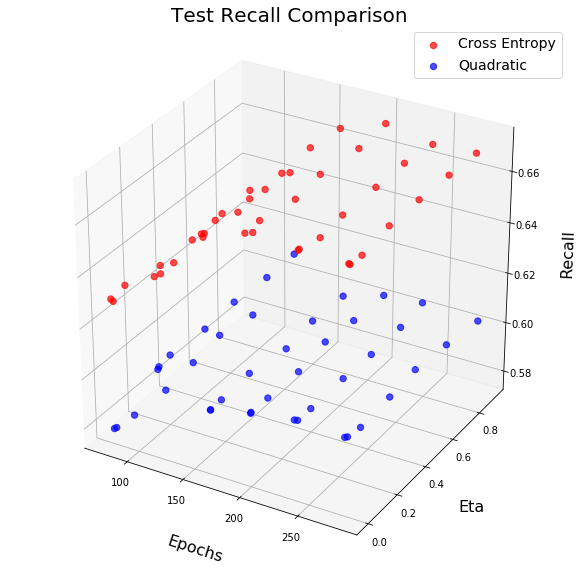

In [105]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

'''
X = epochs
Y = eta
Z = recall

red = cross entropy
blue = quadratic
'''

# add some jitter for overlapping points: https://stackoverflow.com/a/21276920
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

types = ['Cross Entropy', 'Quadratic']
colors = ['red', 'blue']
scatter_dict = {0: {'x': [], 'y': [], 'z': []},
                1: {'x': [], 'y': [], 'z': []}}

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for ep in range(len(epochs_r)):
    for e in range(len(eta_r)):
        scatter_dict[0]['x'].append(epochs_r[ep])
        scatter_dict[0]['y'].append(eta_r[e])
        scatter_dict[0]['z'].append(recall_test_ce[eta_r[e]][ep])

for ep in range(len(epochs_r)):
    for e in range(len(eta_r)):
        scatter_dict[1]['x'].append(epochs_r[ep])
        scatter_dict[1]['y'].append(eta_r[e])
        scatter_dict[1]['z'].append(recall_test_q[eta_r[e]][ep])

for i in range(len(colors)):
    ax.scatter(rand_jitter(scatter_dict[i]['x']),
               rand_jitter(scatter_dict[i]['y']),
               rand_jitter(scatter_dict[i]['z']),
               c=colors[i], marker='o', label=types[i], s=40, alpha=0.7)

plt.title("Test Recall Comparison", fontsize=20, y=1.08)
ax.set_xlabel('Epochs', fontsize=16, labelpad=20)
ax.set_ylabel('Eta', fontsize=16, labelpad=20)
ax.set_zlabel('Recall', fontsize=16, labelpad=20)
ax.legend(loc="upper right", fontsize=14)
plt.show()

The models perform best on the test set when the number of iterations is lowest. This indicates that the models are overfitting to the training data when the number of iterrations is above 120. Classification recall drops off gradually after this point. The quadratic cost function actually produces a higher recall on the training data than cross entropy at 120 iterations.

The linear distribution of points along the Eta axis indicates that the learning rate does not play a large part in the observed recall for the values we have chosen.

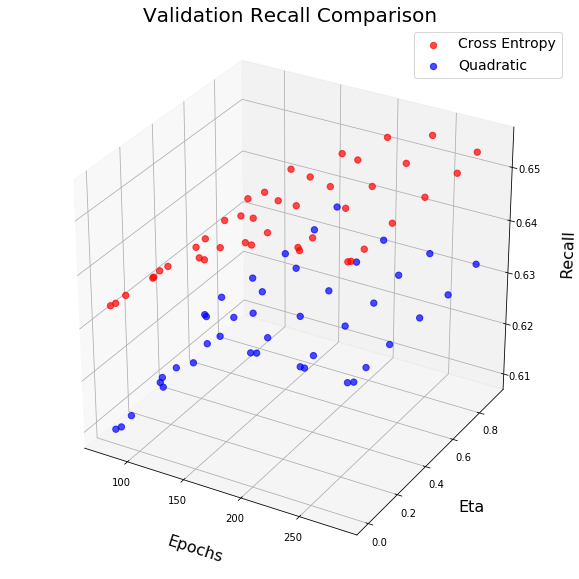

In [106]:
scatter_dict = {0: {'x': [], 'y': [], 'z': []},
                1: {'x': [], 'y': [], 'z': []}}

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for ep in range(len(epochs_r)):
    for e in range(len(eta_r)):
        scatter_dict[0]['x'].append(epochs_r[ep])
        scatter_dict[0]['y'].append(eta_r[e])
        scatter_dict[0]['z'].append(recall_val_ce[eta_r[e]][ep])

for ep in range(len(epochs_r)):
    for e in range(len(eta_r)):
        scatter_dict[1]['x'].append(epochs_r[ep])
        scatter_dict[1]['y'].append(eta_r[e])
        scatter_dict[1]['z'].append(recall_val_q[eta_r[e]][ep])

for i in range(len(colors)):
    ax.scatter(rand_jitter(scatter_dict[i]['x']),
               rand_jitter(scatter_dict[i]['y']),
               rand_jitter(scatter_dict[i]['z']),
               c=colors[i], marker='o', label=types[i], s=40, alpha=0.7)

plt.title("Validation Recall Comparison", fontsize=20, y=1.08)
ax.set_xlabel('Epochs', fontsize=16, labelpad=20)
ax.set_ylabel('Eta', fontsize=16, labelpad=20)
ax.set_zlabel('Recall', fontsize=16, labelpad=20)
ax.legend(loc="upper right", fontsize=14)
plt.show()

We see that the validation recall is also the highest for the lowest number of iterations we have chosen. Here, the cross entropy cost function out performs the quadratic cost function in terms of recall. Again, there is a gradual decrease in recall as the number of iterations increases beyond 120.

When considering the two recall plots above, the classifier that performs best on both the training and validation sets is the cross entropy cost function with 120 epochs. This is the classifier that we will use to compare to scikit-learn.

However, neither of the above plots have given us an insight into the time required to perform classification on our test data. We will make another plot to analyze the test classification time.

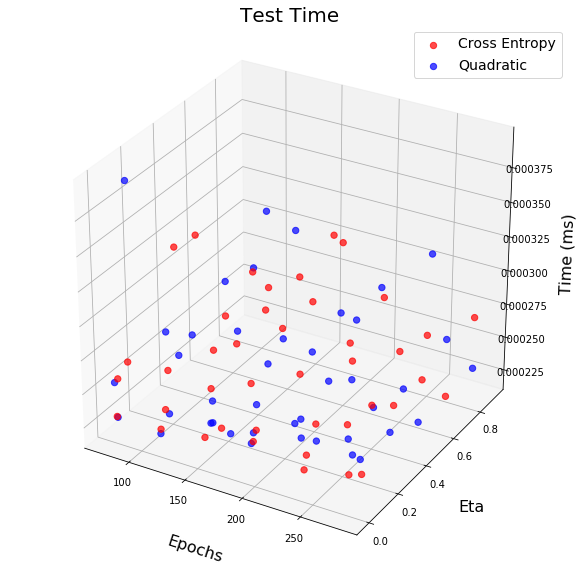

In [107]:
scatter_dict = {0: {'x': [], 'y': [], 'z': []},
                1: {'x': [], 'y': [], 'z': []}}

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for ep in range(len(epochs_r)):
    for e in range(len(eta_r)):
        scatter_dict[0]['x'].append(epochs_r[ep])
        scatter_dict[0]['y'].append(eta_r[e])
        scatter_dict[0]['z'].append(time_ce[eta_r[e]][ep])

for ep in range(len(epochs_r)):
    for e in range(len(eta_r)):
        scatter_dict[1]['x'].append(epochs_r[ep])
        scatter_dict[1]['y'].append(eta_r[e])
        scatter_dict[1]['z'].append(time_q[eta_r[e]][ep])

for i in range(len(colors)):
    ax.scatter(rand_jitter(scatter_dict[i]['x']),
               rand_jitter(scatter_dict[i]['y']),
               rand_jitter(scatter_dict[i]['z']),
               c=colors[i], marker='o', label=types[i], s=40, alpha=0.7)

plt.title("Test Time", fontsize=20, y=1.08)
ax.set_xlabel('Epochs', fontsize=16, labelpad=20)
ax.set_ylabel('Eta', fontsize=16, labelpad=20)
ax.set_zlabel('Time (ms)', fontsize=16, labelpad=20)
ax.legend(loc="upper right", fontsize=14)
plt.show()

Here we see that the eta parameter has an effect on the time it takes to classify new data. We see that the cross entropy based classifier has a larger classification time when the learning rate is higher for the parameters we determined were ideal above. Because we want to minimize the classification time on test data for our real-time deployment case, we will choose a learning rate of 0.01 in order to minimize the effect eta has on the classification time.

### Scikit Learn Comparison
We will compare the classification recall and classification time of our custom multi-layer perceptron to scikit learn. We will use a learning rate of 0.01 and 120 iterations.

In [111]:
%reload_ext memory_profiler
from sklearn.neural_network import MLPClassifier
params = dict(n_hidden=20,
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.01, # learning rate
              random_state=1,
              linear_first_layer=True)

print("-- custom classifier --")
%memit 
custom_mlp = CustomMLP(**params, cross_entrpy=True)
custom_times = try_model(custom_mlp, X, y)
print_try(*custom_times)

-- custom classifier --
peak memory: 365.62 MiB, increment: 0.00 MiB
Mean train time: 0.31788349999999355 ms
Mean test time: 0.00023330000000214567 ms
Mean test recall: 0.6699999999999999
Mean validation recall: 0.6521428571428571


In [114]:
print("-- sklearn classifier --")
%memit 
sk_mlp = MLPClassifier(hidden_layer_sizes=(100,), 
                       solver='lbfgs', 
                       learning_rate_init=0.01, 
                       max_iter=200, 
                       random_state=1)

sk_times = try_model(sk_mlp, X, y)
print_try(*sk_times)

-- sklearn classifier --
peak memory: 365.62 MiB, increment: 0.00 MiB
Mean train time: 1.0860509999999977 ms
Mean test time: 0.0006549000000177329 ms
Mean test recall: 0.6538095238095237
Mean validation recall: 0.6388095238095239


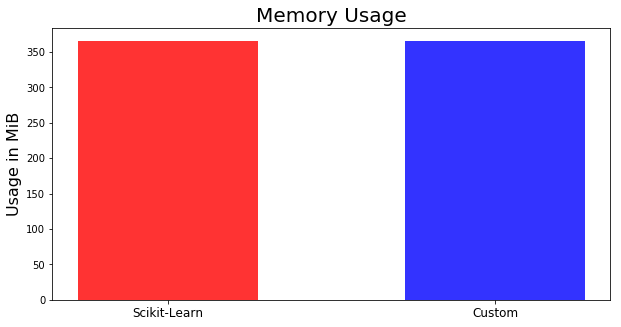

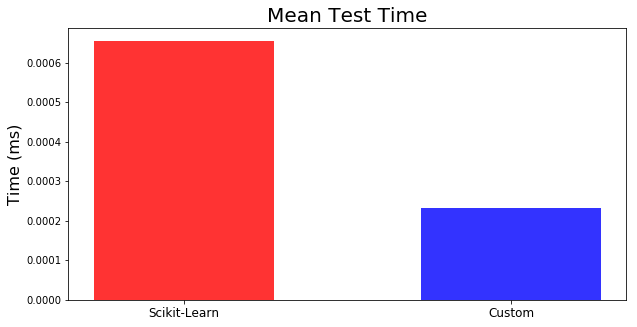

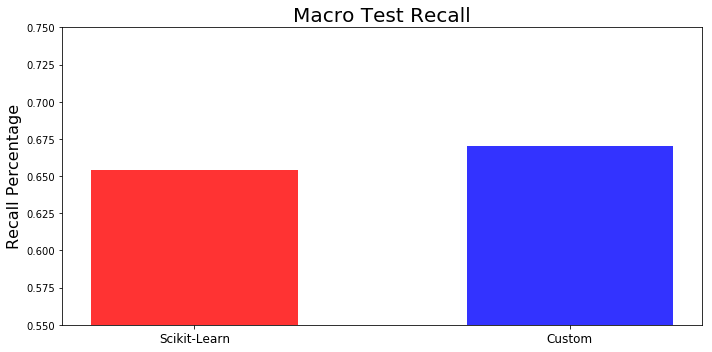

In [118]:
# do memory
# mean test time 
# mean test recall


import matplotlib.pyplot as plt
 
# data to plot
n_groups = 2

stats_memory = (365.62, 365.62)
stats_time = (sk_times[1], custom_times[1])
stats_recall = (sk_times[2], custom_times[2])

# create plot
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.55 
opacity = 0.8
 
rects1 = plt.bar(index, stats_memory, bar_width,
                 alpha=opacity,
                 color=['r', 'b'])
plt.ylabel('Usage in MiB', fontsize=16)
plt.title('Memory Usage', fontsize=20)
plt.xticks(np.arange(2), ('Scikit-Learn', 'Custom'), fontsize=12)
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
rects2 = plt.bar(index, stats_time, bar_width,
                 alpha=opacity,
                 color=['r', 'b'])
plt.ylabel('Time (ms)', fontsize=16)
plt.title('Mean Test Time', fontsize=20)
plt.xticks(np.arange(2), ('Scikit-Learn', 'Custom'), fontsize=12)
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
rects3 = plt.bar(index, stats_recall, bar_width,
                 alpha=opacity,
                 color=['r', 'b'])
plt.ylabel('Recall Percentage', fontsize=16)
plt.ylim([0.55,0.75])
plt.title('Macro Test Recall', fontsize=20)
plt.xticks(np.arange(2), ('Scikit-Learn', 'Custom'), fontsize=12)
 
plt.tight_layout()
plt.show()

CustomMLP and sklearn used about the same amount of memory, however, our model is able to train faster, test faster, and perform more accurately on the test and validation sets than scikit-learn. For these reasons, we would choose our implementation to deploy.

## References
Alex Krizhevsky, 2009: <a href="http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf">Learning Multiple Layers of Features from Tiny Images</a>

Face the Facts USA, 2013: <a href="https://www.facethefactsusa.org/facts/get-numbers-truck">Get the numbers of that truck</a>